---
id: manage-personal-portfolio
title: Managing Personal Portfolio
description: Managing Personal Portfolio
sidebar_position: 1
---

## Personal Portfolio Simulation

This post will be the first in a series where we create a personal finance tool to predict future financial situations. We'll input things like how much money we have to invest, our yearly income, expected monthly expenses, and other important numbers. To start, we'll focus on how much money we expect to come in over time. We'll begin with the basic setup after importing what we need.

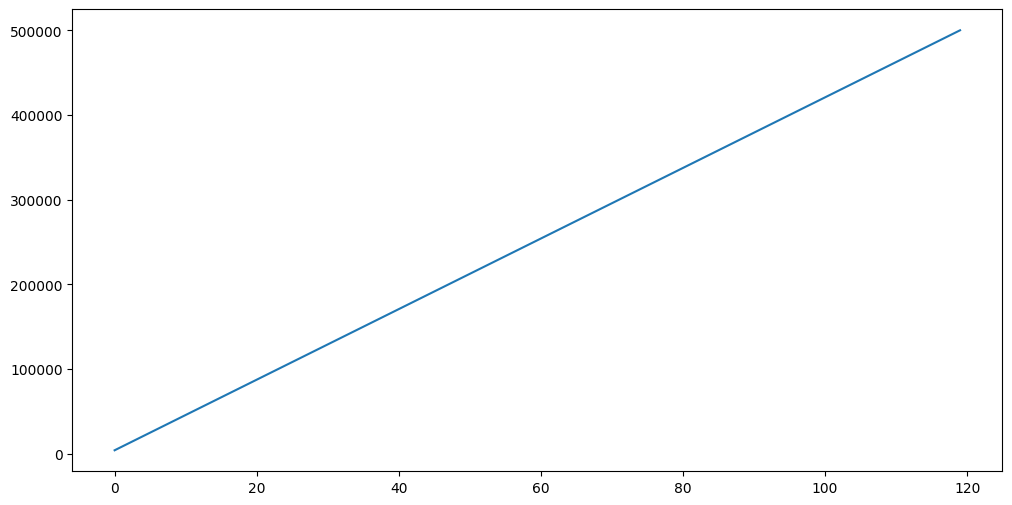

In [1]:
import pandas as pd
import numpy as np
import random
import pandas_datareader.data as web
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)

# Set up model inflows
inflows = {'active_annual_income':50_000}
variables = {'start_date' : "01/01/2020",
             'years': 10}
income_gains_storage = []
months = variables['years'] * 12

for month in range(months):
    income = inflows['active_annual_income'] / 12
    income_gains_storage.append(income)
plt.plot(pd.Series(income_gains_storage).cumsum())
plt.show()

Okay, let's make it straightforward. So, imagine you're earning $50,000 annually. Over 10 years, that's $500,000 in total. But hold on, we need to consider taxes too. Let's keep it simple for now and say there's a flat tax rate of 25%. So, out of your salary, 25% goes to taxes. To keep track of this, we'll add a new entry called "tax_rate" to our list of variables. This will help us remember that 25% of our salary is taken away as taxes. Later on, we might dive into more complex tax systems, but for now, let's stick to this basic setup.

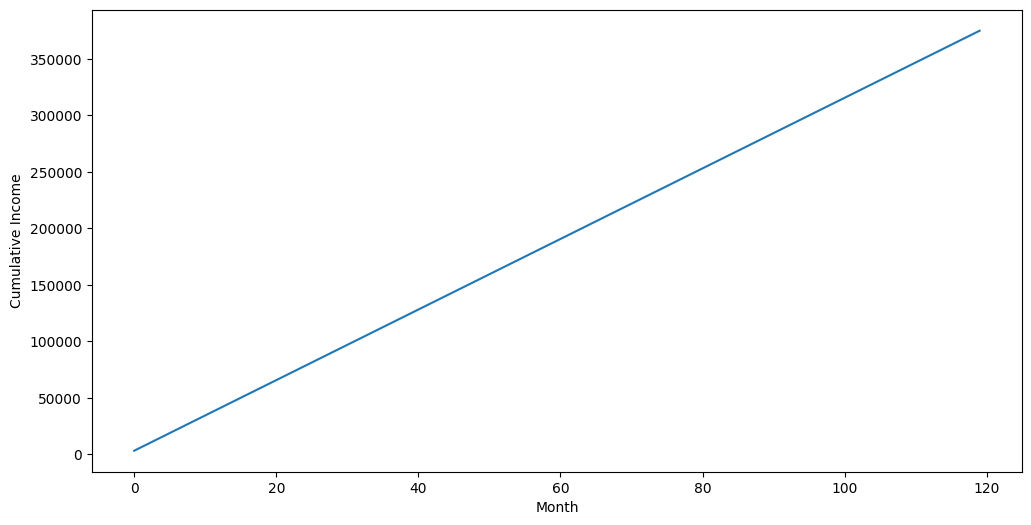

In [2]:
inflows = {'active_annual_income':50_000}
variables = {'start_date' : "01/01/2020",
             'years': 10,
             'tax_on_active_income_gains': 0.25} # add our tax rate on active income in % terms
income_gains_storage = []
months = variables['years'] * 12

for month in range(months):
    # add the effect of the tax rate being applied to our income
    income = (inflows['active_annual_income'] * (1 - variables['tax_on_active_income_gains'])) / 12
    income_gains_storage.append(income)
    
plt.plot(pd.Series(income_gains_storage).cumsum())
plt.xlabel('Month')
plt.ylabel('Cumulative Income')
plt.show()

So, currently, we're left with $375,000 after 10 years, following the 25% tax deduction. But, honestly, this approach is too basic. We're overlooking some critical factors. Firstly, our tax calculation doesn't consider the progressive nature of taxes—where different income levels are taxed at different rates. Secondly, we're ignoring the time value of money. A dollar today is more valuable than a dollar in the future because we could invest it and earn interest. Plus, getting taxed today hurts more than being taxed, say, 5 years from now. If we could keep that dollar, not only could it earn interest, but we could also invest it for potentially higher returns. So, yeah, our current model lacks depth.

We'll soon tackle modeling investment returns. In reality, these returns are unpredictable and vary randomly from one period to another. It's not accurate to assume that if we expect a 10% annual return, we'll receive exactly that each year in nice, evenly spaced installments. The size of returns isn't the only factor determining our final wealth; the order of returns and their volatility matter too.

Let's keep it simple: higher volatility in returns can significantly impact our end wealth. For instance, if we experience a -20% return in one period followed by a +20% return in the next, we'd end up with 96% of our starting capital. On the other hand, if returns are more volatile, like -50% followed by +50%, we'd end up with only 75% of our starting capital. This is despite both scenarios giving us an average return of 0%.

Before we delve into investment strategies, let's incorporate a feature for annual salary increases. We'll assume that our boss will review our salary once a year and offer us an increase based on a percentage of our current annual salary. This increase will take effect immediately. Here's how we'll implement it:

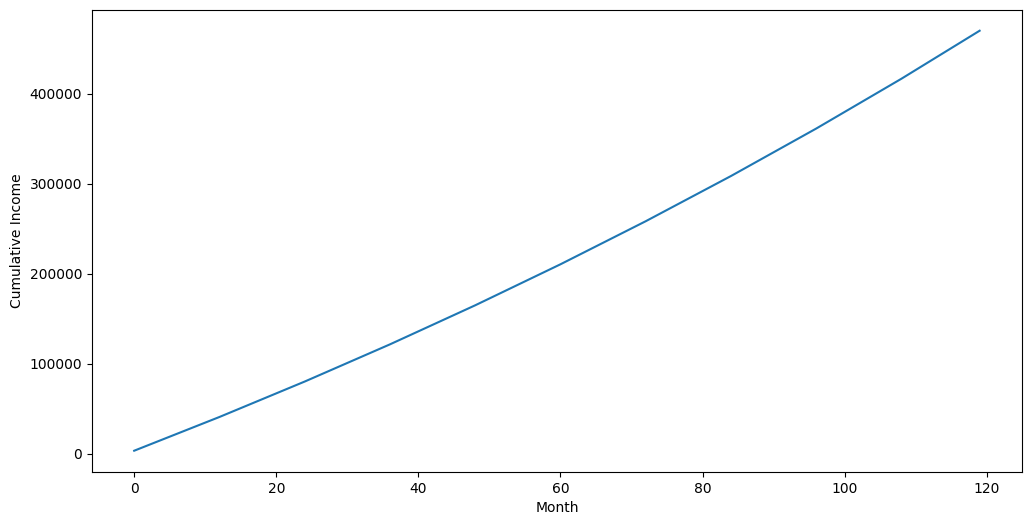

In [3]:
inflows = {'active_annual_income':50_000}
variables = {'start_date' : "01/01/2020",
             'years': 10,
             'tax_on_active_income_gains': 0.25,
             'avg_ann_income_raise':0.05} # add our annual salary raise in % terms
income_gains_storage = []
months = variables['years'] * 12

for month in range(months):
    income = (inflows['active_annual_income'] * (1 - variables['tax_on_active_income_gains'])) / 12
    income_gains_storage.append(income)
    # every 12 months we increase our base salary by the average annual percentage increase
    if (month % 12 == 0) and (month > 0): # we dont want to apply the raise on the very first month
            inflows['active_annual_income'] *= (1 + (variables['avg_ann_income_raise']))
            
plt.plot(pd.Series(income_gains_storage).cumsum())
plt.xlabel('Month')
plt.ylabel('Cumulative Income')
plt.show()

Alright, let's tackle modeling those stochastic investment returns we mentioned earlier. There are various ways to approach this task, and the specific method might vary depending on individual circumstances or beliefs. For the sake of simplicity and illustration, we'll use the S&P 500 Total Return index as a proxy for "the market" and leverage historical data to calculate our values for "average annual returns" and related levels of volatility.

We'll compute these two values—average return and standard deviation. Then, we'll use them as inputs to draw from a Standard Normal distribution. The values obtained will represent our assumed "market returns" over the specified period.

Okay, before we proceed with this logic, let's make a few updates:

1. We'll create a new input in our "inflows" dictionary to represent our starting capital or assets.
2. We'll add the calculated values of average monthly return and volatility to our "variables" dictionary.

Once we've done this, we'll move forward with downloading historic S&P 500 index prices and calculating the average monthly return and standard deviation for a chosen historical period. The calculated values are coming out as a monthly return of 0.6% and a monthly volatility (standard deviation) of 4.15%. These values will be stored for later use as inputs to our Standard Normal distribution.

In [4]:
# download S&P historic prices data
start, end = datetime.datetime(2000, 12, 31), datetime.datetime(2020, 1,1)
tickers = ["^SP500TR"]
sp = pd.DataFrame([web.DataReader(ticker, 'yahoo', start, end).loc[:, 'Adj Close'] for ticker in tickers],
                              index=tickers).T.fillna(method='ffill')
# calculate average monthly return & volatility
sp_monthly_pct_return = sp.resample('M').last().pct_change().mean().values[0]
sp_monthly_std_dev = sp.resample('M').last().pct_change().std().values[0]

inflows = {'active_annual_income':50_000,
           'starting_assets': 250_000} # add value of starting assets
variables = {'start_date' : "01/01/2020",
             'years': 10,
             'tax_on_active_income_gains': 0.25,
             'avg_ann_income_raise':0.05,
             'avg_monthly_market_returns': sp_monthly_pct_return, # add market return data to our inputs
             'avg_monthly_market_volatility': sp_monthly_std_dev} # add market volatility data to our inputs
income_gains_storage = []
investment_gains_storage = [] # create list to store our investment returns
# create a list to store each period's starting assets value
assets_starting_list = [inflows['starting_assets']] # input the first value in the list as today's assets
assets_ending_list = [] # create a list to store each period's ending assets value
months = variables['years'] * 12

for month in range(months):
    
    # small bit of logic to see if this is our first time through the monthly loop
    # and if it is not, then start to use the ending assets from the previous 
    # period as this period's starting assets.
    if assets_ending_list:
        assets_starting_list.append(assets_ending_list[-1])
    
    income = (inflows['active_annual_income'] * (1 - variables['tax_on_active_income_gains'])) / 12
    income_gains_storage.append(income)
    
    if (month % 12 == 0) and (month > 0):
            inflows['active_annual_income'] *= (1 + (variables['avg_ann_income_raise']))
            
    # generate a monthly market return by drawing from a normal distribution      
    market_return = np.random.normal(variables['avg_monthly_market_returns'], 
                                     variables['avg_monthly_market_volatility'],
                                    1)[0]
    
    # calculate the investment return
    investment_return = assets_starting_list[-1] * market_return
    # store the investment return value in a list
    investment_gains_storage.append(investment_return)
    
    # calculate the end of period assets value
    assets_ending = assets_starting_list[-1] + investment_return + income
    # store ending assets value
    assets_ending_list.append(assets_ending)  
    
   
plt.plot(pd.Series(investment_gains_storage).cumsum())
plt.xlabel('Month')
plt.ylabel('Cumulative Investment Returns')
plt.show()

ConnectionError: HTTPSConnectionPool(host='finance.yahoo.com', port=443): Max retries exceeded with url: /quote/%5ESP500TR/history?period1=978215400&period2=1577917799&interval=1d&frequency=1d&filter=history (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000212D15E3BB0>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

Now, as we plot our series of investment returns, we can observe their stochastic nature. Despite having a positive average monthly return used as an input to the Standard Normal function, the inherent randomness of returns means that some months we experience gains while others result in losses.

A slight note to keep in mind: some of the following plots show the series of cumulative monthly investment returns, while others display the series of ending period asset value. These are distinct concepts, although the plots may appear similar at first glance. Ensure to check the y-axis label on each plot for clarity.